<a href="https://colab.research.google.com/github/Hamza-Ali0237/PyTorch-Image-Classification-Projects/blob/main/PyTorch-CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import torchmetrics
from torchmetrics import Accuracy, Recall, Precision

import matplotlib.pyplot as plt

import numpy as np

In [3]:
# Define Transformations

# Train set transformations (Augmentation included)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4471), (0.2023, 0.1994, 0.2010))
])

# Test set transformations (No Augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4471), (0.2023, 0.1994, 0.2010))
])

In [4]:
# Load Dataset

# Train set
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Test set
test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=train_transform
)

testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

100%|██████████| 170M/170M [00:03<00:00, 44.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


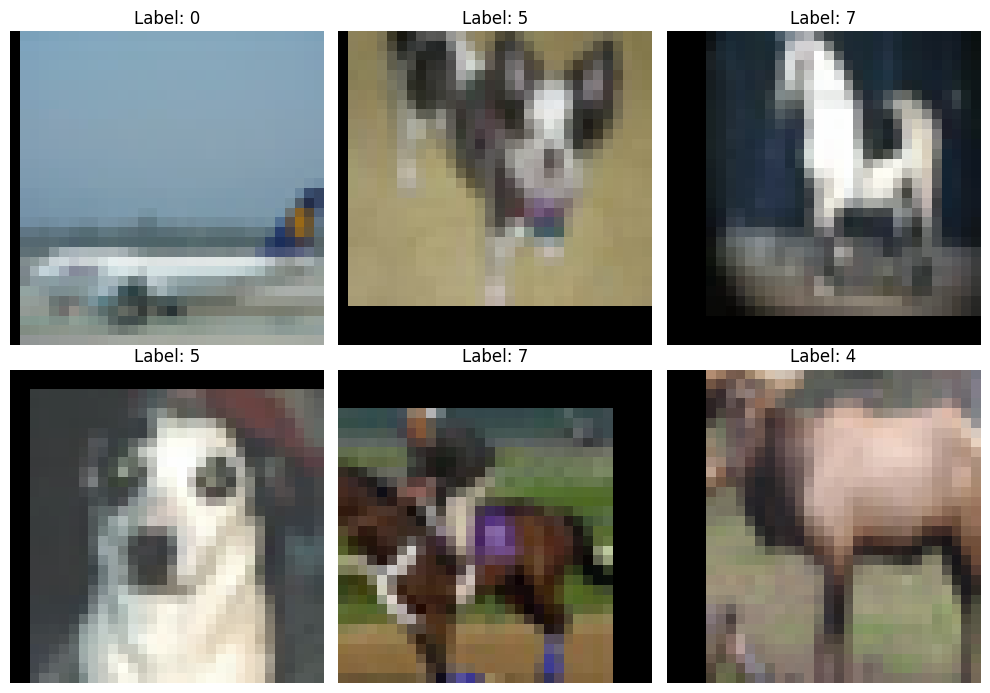

In [5]:
# Display image samples from train set
data_iter = iter(trainloader)
images, labels = next(data_iter)

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes = axes.flatten()

for i in range(6):
    img = images[i].numpy().transpose(1, 2, 0)
    img = img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4471])
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Define CNN Architecture (ResNet18)
class ResNetBlock(nn.Module):
  def __init__(self, channel_in, channel_out, stride, downsample):
    super(ResNetBlock, self).__init__()

    self.conv1 = nn.Conv2d(channel_in, channel_out, 3, stride, 1)
    self.bn1 = nn.BatchNorm2d(channel_out)
    self.conv2 = nn.Conv2d(channel_out, channel_out, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(channel_out)

    self.dropout = nn.Dropout(0.3)

    self.downsample = downsample

    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    i = x

    y = self.conv1(x)
    y = self.bn1(y)
    y = self.relu(y)

    y = self.conv2(y)
    y = self.bn2(y)

    if self.downsample is not None:
      i = self.downsample(x)

    y += i
    y = self.relu(y)
    y = self.dropout(y)

    return y

class ResNet(nn.Module):
  def __init__(self, img_channel, classes_amt):
    super(ResNet, self).__init__()

    self.conv1 = nn.Conv2d(img_channel, 64, 7, 2)
    self.bn1 = nn.BatchNorm2d(54)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(3, 2, 1)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512, classes_amt)

    self.dropout = nn.Dropout(0.25)

    self.layers = [
        self.make_layer(64, 64, 1),
        self.make_layer(64, 128, 2),
        self.make_layer(128, 256, 2),
        self.make_layer(256, 512, 2)
    ]

  def make_layer(self, in_channel, out_channel, stride):
    downsample = None
    if stride != 1:
      downsample = nn.Sequential(
          nn.Conv2d(in_channel, out_channel, 1, stride),
          nn.BatchNorm2d(out_channel)
      )

    block = ResNetBlock(in_channel, out_channel, stride, downsample)
    block = block.to(device)

  def forward(self, x):
    y = self.conv1(x)
    y = self.bn1(y)
    y = self.relu(y)
    y = self.maxpool(y)

    for layer in self.layers:
      y = layer.forward(y)

    y = self.avgpool(y)
    y = torch.flatten(y, 1)
    y = self.fc(y)

    return y

In [7]:
# Specify GPU for traning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Initialize Model
model = ResNet(3, 10).to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters())

In [18]:
# Function for training
def train(model, train_loader, optimizer, criterion, epochs):
    model.train()
    train_loss = []
    train_acc = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    return train_loss, train_acc

In [19]:
# Function for testing
def test(model, test_loader, criterion):
    model.eval()
    test_loss = []
    test_acc = []

    with torch.no_grad():
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = total_loss / len(test_loader)
        epoch_acc = correct / total
        test_loss.append(epoch_loss)
        test_acc.append(epoch_acc)

        print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")

    return test_loss, test_acc

In [20]:
# Train and Test the Model
epochs = 10
train_loss, train_acc = train(model, trainloader, optimizer, criterion, epochs)
test_loss, test_acc = test(model, testloader, criterion)

# Plot Learning Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss", marker='o')
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Testing Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_acc, label="Train Accuracy", marker='o')
plt.plot(range(1, epochs + 1), test_acc, label="Test Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Testing Accuracy")
plt.legend()

plt.show()

RuntimeError: running_mean should contain 64 elements not 54